### Quick Recap:
In the previous notebook, we tested and evaluated the Multinomial Naive Bayes model. We originally tested a *naive* Naive Regression model without inputting much parameters and surprisingly got a good score on our accuracy. Afterwards we created a pipeline that will consist to two stages:
* An instance of TFIDF Vectorizer
* A Multinomial N.B instance

Through GridSearching for the optimal set of hyperparameters for our TFIDF, we got a Train accuracy score: 0.843 and
Test accuracy score: 0.767. Not much of an improvement over the *naive* Multinomial N.B model score. 

Confusion Matrix (shows how our model performed):
* True Negatives: 1928
* False Positives: 452
* False Negatives: 635
* True Positives: 1669
 

### Next Steps: 

In this notebook, we will begin by splitting the data for validation and training purposes. We will apply the TFIDF Vectorizer to test and evaluate a Random Forest model to hopefully identify a production algorithm. We will compare Random Forest model's score to the other 2 models' score and determine which model predicts the subreddits most accurately. In addition to the accuracy score, we also want to prioritize the types of words the models select as the most important feature in order to interpret them and gain insight to help answer the problem statement. Throughout this notebook, we will explain the model process and evaluate the outcome of the Random Forest model. 

In [44]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
!ls

01_Push_Shift_API.ipynb      06_Random_Forest_Model.ipynb
02_Cleaning_EDA.ipynb        Untitled Folder
03_Preprocessing.ipynb       assets
04_LogReg_Model.ipynb        data
05_Naive_Bayes_Model.ipynb


In [46]:
df = pd.read_csv('./data/bp_bts_df_clean.csv')
print(df.shape)
df.head()

(18736, 4)


,body,blackpink,char_count,word_count
0,this is something i can get behind and appreci...,1,1043,188
1,hold the fuck up rock songs i m considering...,1,75,12
2,what time and date is this in pdt 0 am is a b...,1,106,27
3,is there a list last year i remember they str...,1,84,16
4,as a blink i ll wait till mv dropped then i l...,1,149,33


In [47]:
with open('./assets/stopwords.pkl','rb') as f:
    stopwords = pickle.load(f)

We will use train-test-split function to create a validation set before we apply the TFIDF feature-extraction tool (or TFIDF will be impacted by data from our test set). This is once again necessary to determine how well our model will perform on unseen data.

In [48]:
X = df['body']
y = df['blackpink']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42,
                                                   stratify=y,
                                                   test_size= 0.25)

We will instantiate the TFIDFVectorizer

In [50]:
tfidf = TfidfVectorizer(analyzer = "word",
                        strip_accents = 'unicode',
                      stop_words = stopwords,
                      max_features = 6500,
                      max_df=0.95,
                       min_df = 1)
# max_df (higher) is less aggressive; permissible to let words thru

Then we will create a corpus (collection of documents) out of the list of comments. After fitting and transforming TFIDF Vectorizer on the corpus, we will put the vectorized collection of words (6500) into a dataframe.

In [51]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

train_tfidf_df = pd.DataFrame(X_train_tfidf.todense(),   # b/c it is saved as a df...
                                    columns = tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame(X_test_tfidf.todense(), 
                            columns = tfidf.get_feature_names())



In [52]:
test_tfidf_df.head()

,00,000,01,02,04,05,06,07,09,0am,...,yymmdd,zealand,zedd,zelle,zero,zeus,zhou,zodiac,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will fit the model using `blackpink` as the target variable.
Then we will instantiate the GridSearchCV for RandomForestClassifier to fit and get a score on the training set. We will compare that score to the testing set score to determine the performance of it.

We also wanted to find the maximum depth of the tree to use that as a side-line to help us determine an optimal number of depth for this model. This idea was inspired by this [link](https://stackoverflow.com/questions/26602369/how-to-find-out-the-size-of-a-sklearn-decision-tree-in-python). The maximum depth for this tree is 1,218. 


In [42]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_tfidf_df, y_train)

max([t.tree_.max_depth for t in rf.estimators_])

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1218

In [11]:
rf= RandomForestClassifier(random_state=42)

params = {
    'min_samples_split':[3, 5, 10],
    'n_estimators':[150, 200],
    'max_depth': [1000, 1200]
    
}

gs = GridSearchCV(rf, 
                  param_grid=params, 
                  return_train_score=True,
                  cv=3
                 )

gs.fit(train_tfidf_df, y_train)
print(gs.best_score_) #cross val score from best_params_
print(gs.score(train_tfidf_df, y_train))
gs.best_params_

0.7198263592371192
0.9846285226302306


{'max_depth': 1200, 'min_samples_split': 5, 'n_estimators': 150}

In [12]:
gs.score(test_tfidf_df, y_test)

0.7188300597779675

This is a significant gap between the two scores, indicating the model is heavily over-fit. On the other hand, the Random Forest model works in minimizing the error on the training set; therefore, the accuracy score of the training set would be *naturally* better than our  test set score results. We will dive a bit deeper into tuning some of the hyperparameters to see if this is something that we can improve.

In [77]:
rf= RandomForestClassifier(random_state=42)

params = {
    'min_samples_split':[5],
    'n_estimators':[100, 130, 150],
    'max_depth': [1200]
    
}

gs = GridSearchCV(rf, 
                  param_grid=params, 
                  return_train_score=True,
                  cv=3
                 )

gs.fit(train_tfidf_df, y_train)
print(gs.best_score_) #cross val score from best_params_
print(gs.score(train_tfidf_df, y_train))
gs.best_params_

0.7207514944491887
0.9846996868773128


{'max_depth': 1200, 'min_samples_split': 5, 'n_estimators': 130}

In [79]:
gs.score(test_tfidf_df, y_test)

0.7175491033304867

The GridSearchCV found that the best parameters for the Random Forest model is when the min_samples_split is 5, n_estimators is 130, max_depth is 1,200, and all other parameters held in their default set. 
The training score is 0.98, while the testing score is 0.72.

The model clearly performed significantly worse on the testing set, with a 26% gap between the two scores. Although this is an improvement over the baseline model, the difference between this model's training/testing scores indicates a high variance and overfit model. However as mentioned above, the Random Forest model works in minimizing the error on the training set; therefore, the accuracy score of the training set being higher than the score of the testing set is relatively expected. Nevertheless, further fine-tuning the hyperparameters through Randomized Search over GridSearchCV may prove to be a much more efficient choice. 


-----

In [80]:
gs.best_estimator_.feature_importances_
# a lot of these are pretty small numbers.

array([6.32327652e-05, 2.74881869e-05, 3.78930120e-06, ...,
       2.62278253e-06, 6.00321263e-05, 1.23440650e-05])

We will now create a dataframe that aligns the important features from the model to correspond to its' feature term (word).

In [81]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_,  #feature importances are in our best estimator
                               train_tfidf_df.columns, 
                               columns=['importance'])

Text(0, 0.5, 'Feature')

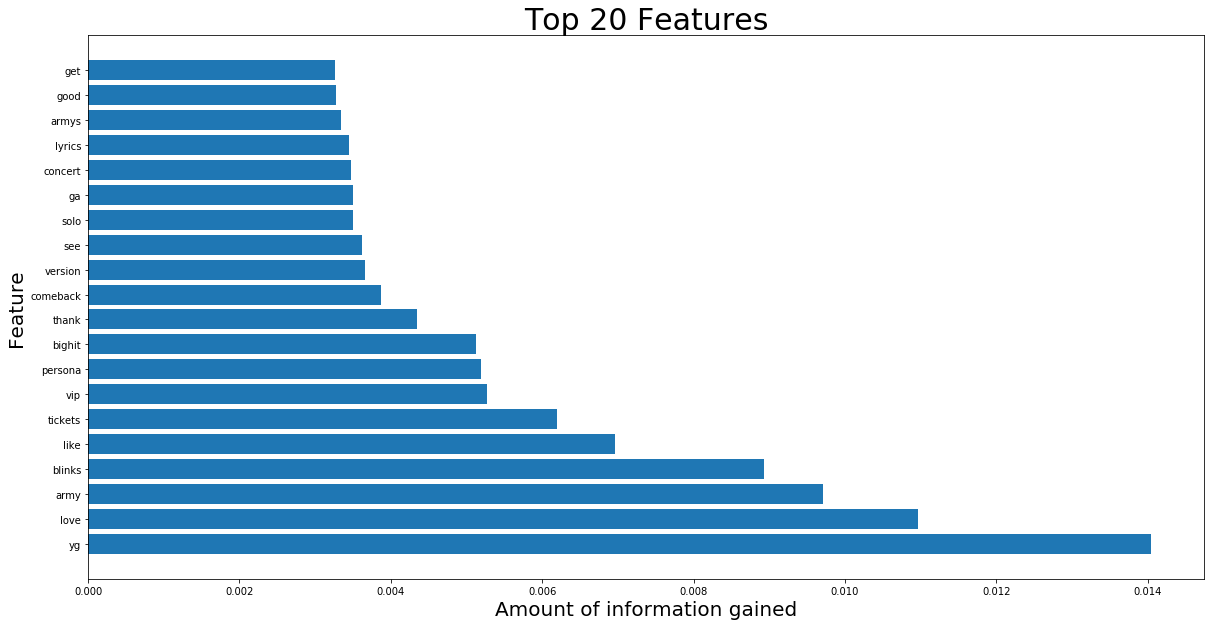

In [82]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

# amount of information gained between our classes.

The plot above displays the top 20 important features identfied by the model. The model picked these specific features because it has the most amount of information gained. In other words, for this Random Forest model these top 20 features are most important in explaining the target variable (predicting whether a comment is from a Blackpink subreddit or Bts subreddit). 

We can see that most of these words are similar to the other top 20 features pulled by the different models located in our prior notebooks. This models' important features adds no new significant information. 